In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import gvar as gv

In [2]:
# Helper function for plotting gvars

def plot_gvcorr(gc, color='blue', log_scale=False, offset=0.0, x=None, xr_offset=True, 
    label=None, marker='o', markersize=8, capthick=0, open_symbol=False, fill=False, linestyle=' ', 
    eb_linestyle=' ', figax=None, xerr=False):

    if figax is None:
        fig = plt.figure(figsize=(8,6))
        ax = plt.subplot(111)
    else:
        # Unpack figure, current axis
        fig, ax = figax

    if x is None:
        x = np.arange(0,len(gc))

    if fill:
        y = np.asarray([gv.mean(g) for g in gc])
        yerr = np.asarray([gv.sdev(g) for g in gc])
        ax.plot(x+offset, y, color=color, label=label)
        ax.fill_between(x+offset, y-yerr, y+yerr, alpha=0.5, edgecolor='k', facecolor=color)
    else:
        eb_args = {
            'x': x + offset,
            'y': [ gv.mean(g) for g in gc],
            'yerr': [ gv.sdev(g) for g in gc],
            'marker': marker,
            'markersize': markersize,
            'capthick': capthick,
            'linestyle': linestyle,
            'color': color,
            'label': label,
        }
        
        if (xerr):
            eb_args['x'] = [ gv.mean(g) for g in (x + offset) ]
            eb_args['xerr'] = [ gv.sdev(g) for g in (x + offset) ]
        if (open_symbol):
            eb_args['mfc'] = 'None'
            eb_args['mec'] = color
            eb_args['mew'] = 1
                        
        eb = ax.errorbar(**eb_args)
 
        if eb_linestyle != ' ':
            eb[-1][0].set_linestyle(eb_linestyle)

    if (log_scale):
        ax.yscale('symlog')
    
    if (xr_offset):
        ax.set_xlim(x[0]-0.2, x[-1]+0.2)

    return fig, ax


__Test case:__ we will adopt a multinormal distribution with data size $d=3$.  We compute the inverse of the asymptotic (true) covariance matrix for use in estimators below; computing the inverse of the sample covariance can result in additional bias when it is not diagonal. 

In [8]:
test_mu = np.array([0.6, 0.9, 1.2])
test_C = np.array([
    [1.0, 0.4, 0.1],
    [0.4, 1.0, 0.0],
    [0.1, 0.0, 2.0],
])

inv_C = np.linalg.inv(test_C)

The code below will compute K-L divergence terms in a Monte Carlo loop.  We draw samples of size $N$, but repeat the process $M$ times in order to simulate expectation values over the true distribution ${\rm pr}_T(z)$ specified in the cell above.  (This can be thought of as simple Monte Carlo evaluation of the integral $E_z[...] = \int dz\ {\rm pr}_T(z) [...]$.)

In [14]:
def get_sample(N):
    return np.random.multivariate_normal(test_mu, test_C, N)

def resample(M, N, statistic):
    all_results = []
    
    for _ in range(M):
        ys = get_sample(N)
        z = get_sample(1).flatten()
        all_results.append(statistic(ys, z))
    
    return all_results

def chi2_perfect(ys, z):
    ybar = np.mean(ys, axis=0)
    Cbar = np.cov(ys.T)
    
    delta = ybar - z
    
    return -0.5 * delta.T @ inv_C @ delta
    
def KL_true(ys, z):
    delta = test_mu - z
    return -0.5 * delta.T @ inv_C @ delta

First, let's verify the result for the first term in the K-L divergence,
$$
E_z[\log {\rm pr}_T(z)] = -\frac{d}{2} \log (2\pi) - \frac{1}{2} \log \det \Sigma_T - \frac{d}{2}
$$

The first two factors come from normalization so we can just skip them completely - the numerical answer we get from our simulation should be $-d/2 = -3/2$.

In [29]:
def compute_KL_sample(M, N):
    all_KL = resample(M, N, KL_true)
    
    return gv.gvar(np.mean(all_KL), np.std(all_KL) / np.sqrt(M))

In [30]:
all_KL = []
Ms = np.array([100, 200, 400, 500, 800, 1000, 2000, 5000])
for M in Ms:
    all_KL.append((compute_KL_sample(M, 1000)))


Text(0.5, 0, '$\\log (1/M)$')

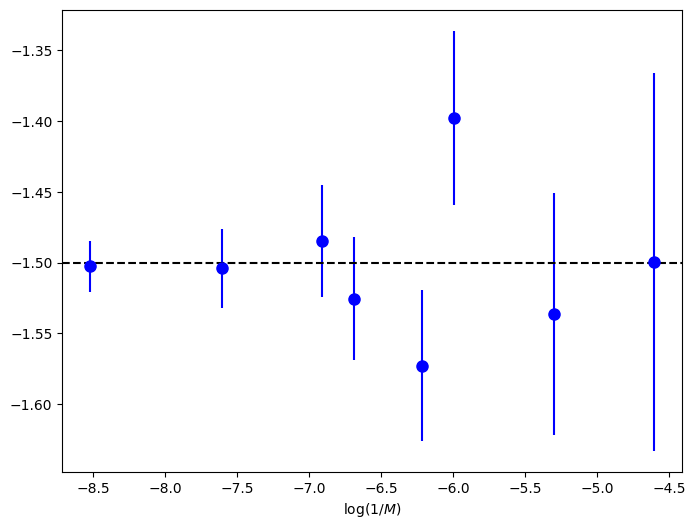

In [31]:
plot_gvcorr(all_KL, x=np.log(1/Ms), xr_offset=False)
plt.axhline(-len(test_mu)/2, ls='--', color='k')

plt.xlabel('$\log (1/M)$')

Next, the second term in the K-L divergence:

$$
E_z[\log {\rm pr}(z | M_\mu, \mathbf{a}^\star)] \simeq -\frac{1}{2N} {\rm AIC}_\mu \\
= -\frac{1}{2N} \left[ \hat{\chi}^2 + 2k + (N-1)d \right]
$$
For the perfect model we have $\hat{\chi}^2 = 0$, and the number of parameters is $k = d$, so:

$$
E_z[\log {\rm pr}(z | M_\mu, \mathbf{a}^\star)]^{\rm perf} \simeq -\frac{(N+1)d}{2N} = -\frac{d}{2} - \frac{d}{2N}.
$$

Thus, we predict that if we calculate $E_z[\log {\rm pr}(z | M_\mu, \mathbf{a}^\star)]^{\rm perf}$ directly by Monte Carlo, we should find $-3/2$ asymptotically, but with a small correction that depends on $N$.  Below we will set $N = 25$, which gives an expected bias correction of $-3/50 = -0.06$.

In [22]:
def compute_chi2P_sample(M, N):
    all_chi2 = resample(M, N, chi2_perfect)
    
    return gv.gvar(np.mean(all_chi2), np.std(all_chi2) / np.sqrt(M))

In [23]:
all_chi2 = []
Ns = 25
Ms = np.array([100, 200, 400, 500, 800, 1000, 2000, 5000, 10000])
for M in Ms:
    all_chi2.append((compute_chi2P_sample(M, Ns)))
    

Text(0.5, 0, '$\\log (1/M)$')

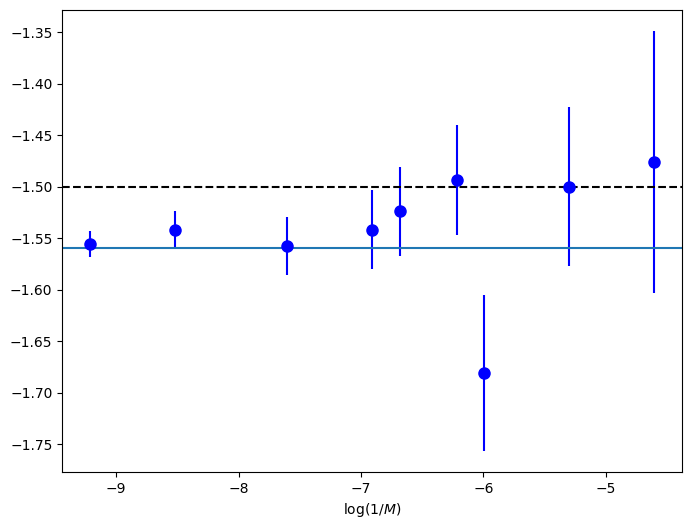

In [27]:
plot_gvcorr(all_chi2, x=np.log(1/Ms), xr_offset=False)
plt.axhline(-len(test_mu)/2, ls='--', color='k')    # Asymptotic N --> infinity result
plt.axhline(-len(test_mu)/2 - len(test_mu)/(2*Ns))  # Matching the AIC_perfect estimator?

plt.xlabel('$\log (1/M)$')

We see excellent agreement as $M \rightarrow \infty$ with the predicted, bias-corrected result!  This confirms that the standard $\chi^2 + 2k$ AIC formula with $k \rightarrow d_{\rm C}$ gives the right answer including the bias correction.